In [14]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

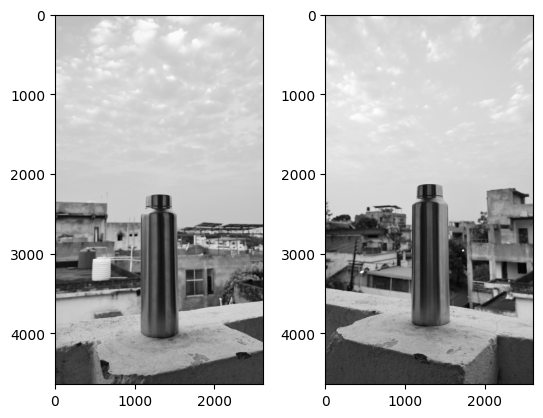

In [15]:
# Load the two images in grayscale
img1_color = cv2.imread('bottle1.jpg')
img2_color = cv2.imread('bottle2.jpg')

img1 = cv2.cvtColor(img1_color, cv2.COLOR_BGR2GRAY)
img2 = cv2.cvtColor(img2_color, cv2.COLOR_BGR2GRAY)

plt.subplot(1, 2, 1)
plt.imshow(img1, cmap="gray")
plt.subplot(1, 2, 2)
plt.imshow(img2, cmap="gray")

In [16]:
# Resize for better visualization (optional)
img1 = cv2.resize(img1, (600, int(img1.shape[0] * 600 / img1.shape[1])))
img2 = cv2.resize(img2, (600, int(img2.shape[0] * 600 / img2.shape[1])))

In [17]:
# Initialize ORB detector (or use AKAZE or SIFT if available)
orb = cv2.ORB_create(nfeatures=1000)

# Detect and compute descriptors
kp1, des1 = orb.detectAndCompute(img1, None)
kp2, des2 = orb.detectAndCompute(img2, None)

# Match descriptors using Brute Force Hamming matcher
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=False)
matches = bf.knnMatch(des1, des2, k=2)

In [18]:
# Apply Lowe's ratio test
good = []
for m, n in matches:
    if m.distance < 0.75 * n.distance:
        good.append(m)

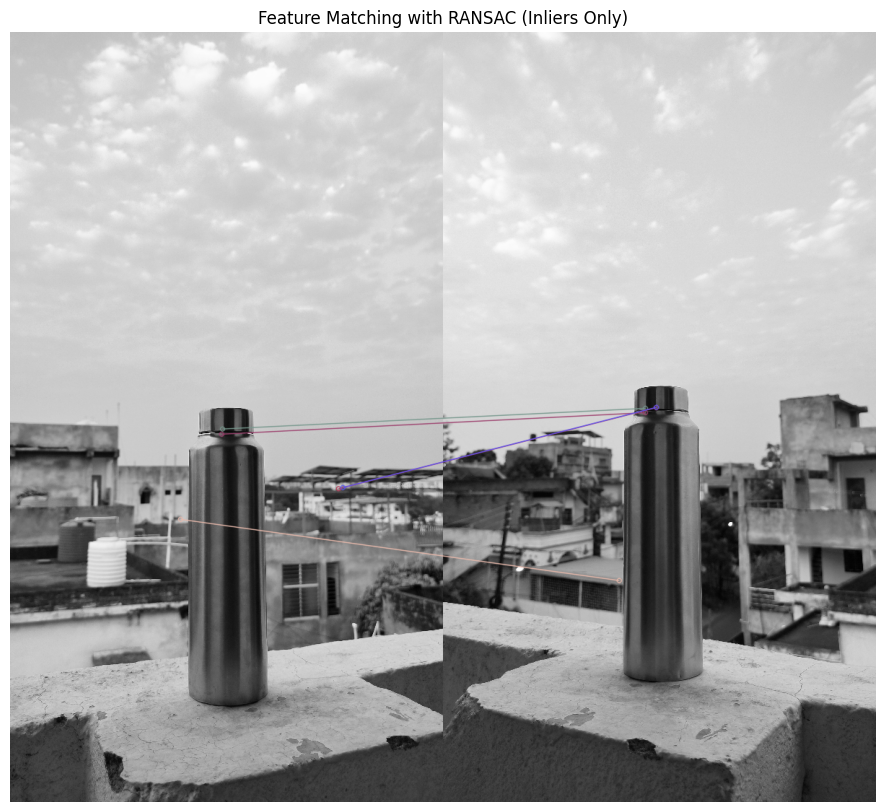

Estimated Homography:
 [[-7.19869773e-01 -2.08495226e-01  2.97766804e+02]
 [-1.20713951e+00 -4.54522167e-01  5.51748540e+02]
 [-2.40098251e-03 -7.20076949e-04  1.00000000e+00]]


In [19]:
# Extract matched keypoints
if len(good) >= 10:
    src_pts = np.float32([kp1[m.queryIdx].pt for m in good]).reshape(-1, 1, 2)
    dst_pts = np.float32([kp2[m.trainIdx].pt for m in good]).reshape(-1, 1, 2)

    # Apply RANSAC to filter outliers and compute homography
    H, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)

    # Use mask to draw inliers only
    inliers = [good[i] for i in range(len(good)) if mask[i]]

    # Draw matches after RANSAC
    matched_img = cv2.drawMatches(img1, kp1, img2, kp2, inliers, None,
                                  flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

    plt.figure(figsize=(20, 10))
    plt.imshow(matched_img)
    plt.title("Feature Matching with RANSAC (Inliers Only)")
    plt.axis('off')
    plt.show()

    # Optional: print transformation matrix
    print("Estimated Homography:\n", H)

else:
    print("Not enough matches found - %d/%d" % (len(good), 10))

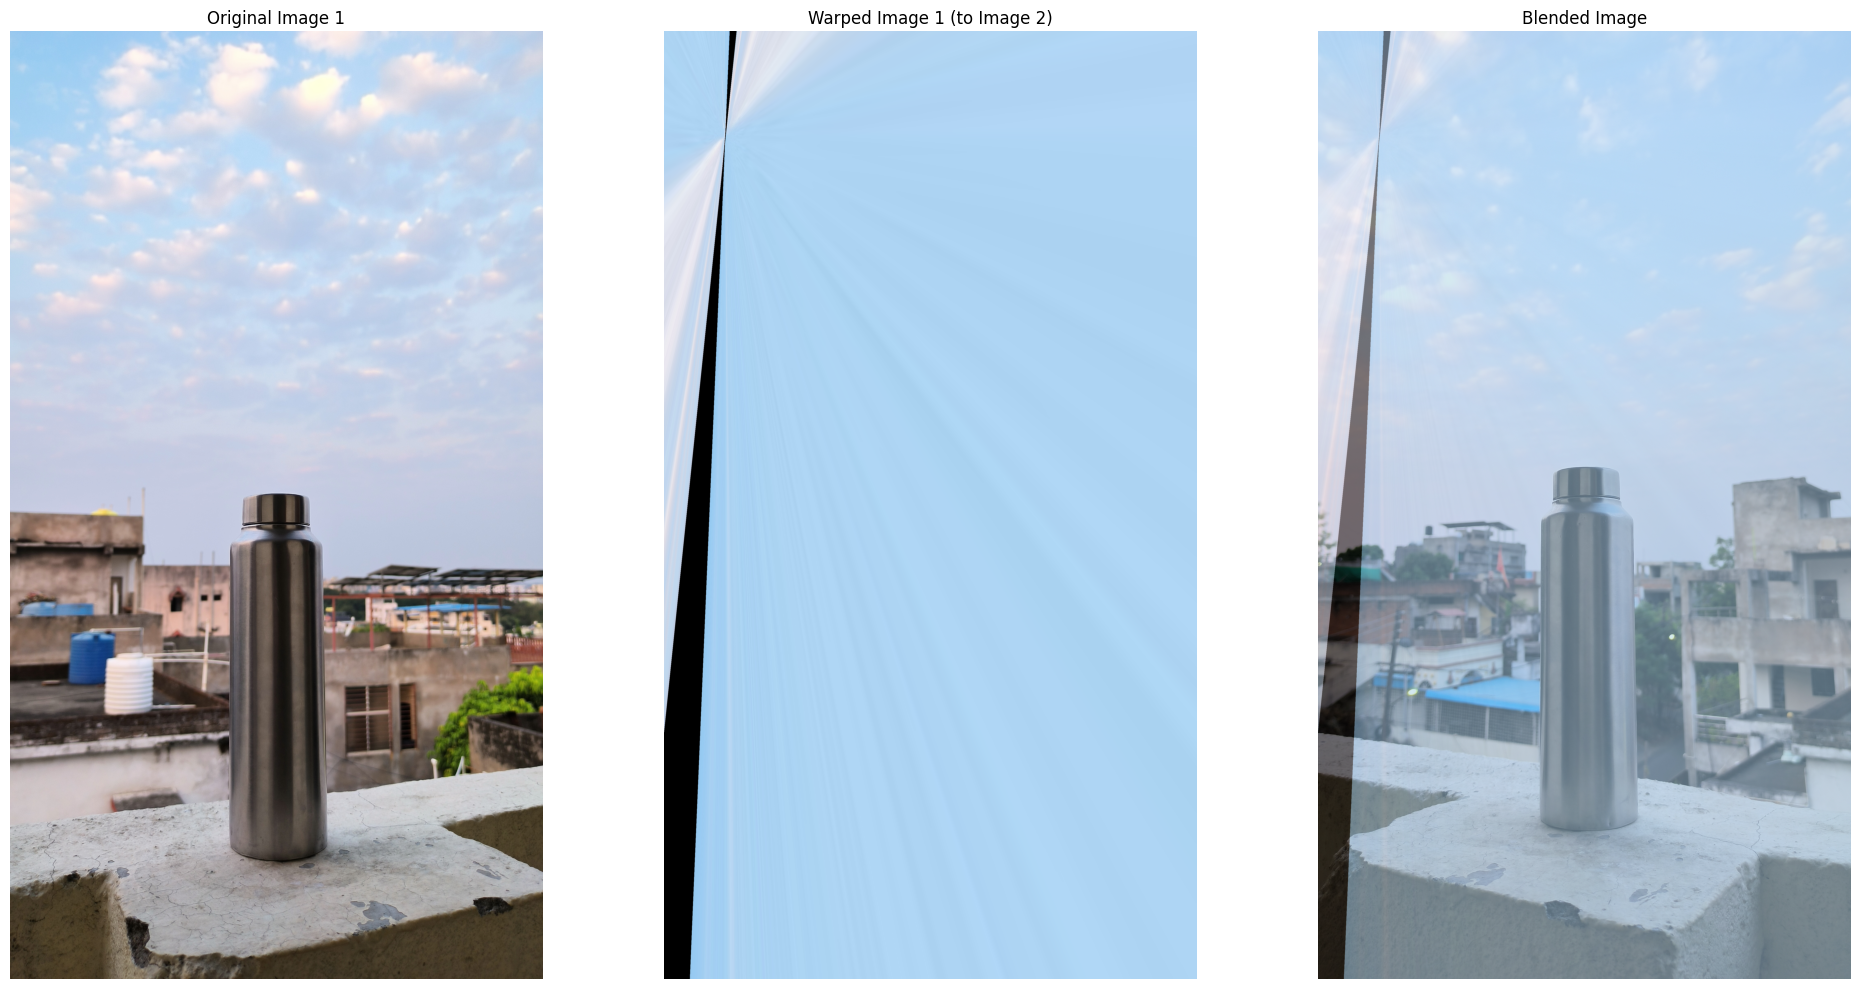

Homography Matrix:
 [[-7.19869773e-01 -2.08495226e-01  2.97766804e+02]
 [-1.20713951e+00 -4.54522167e-01  5.51748540e+02]
 [-2.40098251e-03 -7.20076949e-04  1.00000000e+00]]


In [20]:
if len(good) >= 10:
    src_pts = np.float32([kp1[m.queryIdx].pt for m in good]).reshape(-1, 1, 2)
    dst_pts = np.float32([kp2[m.trainIdx].pt for m in good]).reshape(-1, 1, 2)

    # Estimate homography using RANSAC
    H, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)

    # Warp img1 onto img2 using the homography
    height, width, _ = img2_color.shape
    warped_img1 = cv2.warpPerspective(img1_color, H, (width, height))

    # Overlay: blend both images for visualization
    blended = cv2.addWeighted(warped_img1, 0.5, img2_color, 0.5, 0)

    # Show all images
    plt.figure(figsize=(20, 10))

    plt.subplot(1, 3, 1)
    plt.imshow(cv2.cvtColor(img1_color, cv2.COLOR_BGR2RGB))
    plt.title("Original Image 1")
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(cv2.cvtColor(warped_img1, cv2.COLOR_BGR2RGB))
    plt.title("Warped Image 1 (to Image 2)")
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(cv2.cvtColor(blended, cv2.COLOR_BGR2RGB))
    plt.title("Blended Image")
    plt.axis('off')

    plt.tight_layout()
    plt.show()

    print("Homography Matrix:\n", H)

else:
    print("Not enough good matches found.")